<a href="https://colab.research.google.com/github/rohitrrk22/Deep-Learning/blob/master/Deep_Learning_NLP/Spam_Filter_For_Quora_Questions/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

In [2]:
import pandas as pd
import numpy as np

In [3]:
!wget https://www.dropbox.com/sh/kpf9z73woodfssv/AAAw1_JIzpuVvwteJCma0xMla

--2020-08-30 05:58:53--  https://www.dropbox.com/sh/kpf9z73woodfssv/AAAw1_JIzpuVvwteJCma0xMla
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/kpf9z73woodfssv/AAAw1_JIzpuVvwteJCma0xMla [following]
--2020-08-30 05:58:53--  https://www.dropbox.com/sh/raw/kpf9z73woodfssv/AAAw1_JIzpuVvwteJCma0xMla
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8eebcb3eea57ed4c87786f158e.dl.dropboxusercontent.com/zip_download_get/Ah0iDj4aCXSmbxhJDzaXtaUNkp31z33cBcI6o9jBImUb53MEL15nATQSsvX6JD-N94W28Z8cCy3UWZqAXWlQF0-NU_XCQSxR2DXTWaSrDLU6qA [following]
--2020-08-30 05:58:54--  https://uc8eebcb3eea57ed4c87786f158e.dl.dropboxusercontent.com/zip_download_get/Ah0iDj4aCXSmbxhJDzaXtaUNkp31z33cBcI6o9jBImUb53MEL15nATQSsvX6JD-N94W28Z8cCy3UWZqAXWlQF0

In [4]:
train = pd.read_csv(r'/content/spam_quora_data',encoding='ISO-8859-1')

In [5]:
train.dropna(axis=0 , how='any',inplace=True)
train.rename(columns={'PK': 'qid'},inplace=True)

In [6]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0.0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0.0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0.0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0.0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0.0


In [7]:
from sklearn.model_selection import train_test_split

#Train & Test dataset
quora_train,quora_test=train_test_split(train,test_size=0.2,random_state=2)

del quora_train["qid"]

In [8]:
quora_train.shape

(1044897, 2)

In [9]:
quora_test.shape

(261225, 3)

In [10]:
#Train dataset split into train & validation dataset
quora_trn,quora_val=train_test_split(quora_train,test_size=0.2,random_state=2)

In [11]:
x_train=quora_trn['question_text']
y_train=quora_trn['target']
x_test=quora_val['question_text']     
y_test=quora_val['target']

In [12]:
x_train.shape

(835917,)

In [13]:
x_test.shape

(208980,)

In [14]:
#Getting the Word2Vec Pretrained Embeddings
!wget http://vectors.nlpl.eu/repository/20/0.zip   

--2020-08-30 05:59:30--  http://vectors.nlpl.eu/repository/20/0.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.225
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344050746 (328M) [application/zip]
Saving to: ‘0.zip’

0.zip               100%[===================>] 328.11M  9.64MB/s    in 41s     

2020-08-30 06:00:13 (8.06 MB/s) - ‘0.zip’ saved [344050746/344050746]



In [16]:
!unzip 0.zip

Archive:  0.zip
replace meta.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace model.bin? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace model.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace README? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [25]:
!rm -rf 0.zip README meta.json model.bin

In [17]:
embeding_index={}

f=open('/content/model.txt',encoding='utf-8')

for i,line in enumerate(f):
    if i==0:continue
    values=line.split()
    word=values[0].split('_')[0]
    coefs=np.asarray(values[1:],dtype='float32')
    embeding_index[word]=coefs
f.close()

In [18]:
len(embeding_index)

152494

In [ ]:
list(embeding_index.keys())[:10]

['say', 'go', 'make', 'get', 'one', 'see', 'time', 'take', 'know', 'year']

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM,Activation,Dense,Input,Embedding,Dropout
from tensorflow.keras.models import Model
from nltk import word_tokenize

In [20]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [21]:
sent_lens=[len(word_tokenize(x)) for x in x_train]

In [22]:
np.percentile(sent_lens,95)

30.0

In [23]:
max_len=30

tk=Tokenizer(char_level=False,split=' ')

tk.fit_on_texts(x_train)

seq_train=tk.texts_to_sequences(x_train)
seq_test=tk.texts_to_sequences(x_test)

vocab_size=len(tk.word_index)

seq_train_matrix=sequence.pad_sequences(seq_train,maxlen=max_len)
seq_test_matrix=sequence.pad_sequences(seq_test,maxlen=max_len)

In [26]:
vocab_size

173214

In [27]:
embedding_matrix=np.zeros((vocab_size+1,300))
words_not_available=0
for word,i in tk.word_index.items():
    embed_vector=embeding_index.get(word)
    if embed_vector is not None:
        embedding_matrix[i]=embed_vector
    else:
      words_not_available+=1

In [28]:
words_not_available

134467

In [29]:
# LSTM Model with Word2Vec Embedding Layer

inputs=Input(name='text_input',shape=[max_len])
embed=Embedding(vocab_size+1,300,input_length=max_len,mask_zero=True,
                weights=[embedding_matrix],trainable=False)(inputs)
lstm_layer=LSTM(150)(embed)
dense1=Dense(75,activation='relu')(lstm_layer)
drop1=Dropout(0.2)(dense1)
dense2=Dense(35,activation='relu')(drop1)
drop2=Dropout(0.2)(dense2)
dense3=Dense(15,activation='relu')(drop2)
drop3=Dropout(0.2)(dense3)
final_layer=Dense(1,activation='sigmoid')(drop3)

model=Model(inputs=inputs,outputs=final_layer)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 300)           51964500  
_________________________________________________________________
lstm (LSTM)                  (None, 150)               270600    
_________________________________________________________________
dense (Dense)                (None, 75)                11325     
_________________________________________________________________
dropout (Dropout)            (None, 75)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 35)                2660      
_________________________________________________________________
dropout_1 (Dropout)          (None, 35)               

In [30]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history=model.fit(seq_train_matrix,y_train,validation_data=(seq_test_matrix,y_test),epochs=2,batch_size=150)

Epoch 1/2
5573/5573 [==============================] - 398s 71ms/step - loss: 0.1731 - accuracy: 0.9401 - val_loss: 0.1618 - val_accuracy: 0.9427
Epoch 2/2
5573/5573 [==============================] - 398s 71ms/step - loss: 0.1563 - accuracy: 0.9430 - val_loss: 0.1507 - val_accuracy: 0.9449


In [31]:
model.evaluate(seq_test_matrix, y_test, batch_size=120)

1742/1742 [==============================] - 14s 8ms/step - loss: 0.1507 - accuracy: 0.9449


[0.15068425238132477, 0.9449277520179749]

In [32]:
p=model.predict(seq_test_matrix)

In [33]:
from sklearn.metrics import roc_auc_score,confusion_matrix
roc_auc_score(y_test,p)

0.9043269017310566

In [34]:
#Merging train and validation data set
X_train=pd.concat([x_train,x_test],axis=0)
Y_train=pd.concat([y_train,y_test],axis=0)

quora_test.reset_index(drop=True,inplace=True)

X_test=quora_test['question_text']     
Y_test=quora_test['target']

In [35]:
sent_lens=[len(word_tokenize(x)) for x in X_train]

In [36]:
np.percentile(sent_lens,95)

30.0

In [37]:
max_len=30

tk=Tokenizer(char_level=False,split=' ')

tk.fit_on_texts(X_train)

seq_train=tk.texts_to_sequences(X_train)
seq_test=tk.texts_to_sequences(X_test)

vocab_size=len(tk.word_index)

seq_train_matrix=sequence.pad_sequences(seq_train,maxlen=max_len)
seq_test_matrix=sequence.pad_sequences(seq_test,maxlen=max_len)

In [38]:
vocab_size

196220

In [39]:
embedding_matrix=np.zeros((vocab_size+1,300))
words_not_available=0
for word,i in tk.word_index.items():
    embed_vector=embeding_index.get(word)
    if embed_vector is not None:
        embedding_matrix[i]=embed_vector
    else:
      words_not_available+=1

In [40]:
words_not_available

155883

In [41]:
# LSTM Model with Glove Embedding Layer

inputs=Input(name='text_input',shape=[max_len])
embed=Embedding(vocab_size+1,300,input_length=max_len,mask_zero=True,
                weights=[embedding_matrix],trainable=False)(inputs)
lstm_layer=LSTM(150)(embed)
dense1=Dense(75,activation='relu')(lstm_layer)
drop1=Dropout(0.2)(dense1)
dense2=Dense(35,activation='relu')(drop1)
drop2=Dropout(0.2)(dense2)
dense3=Dense(15,activation='relu')(drop2)
drop3=Dropout(0.2)(dense3)
final_layer=Dense(1,activation='sigmoid')(drop3)

model=Model(inputs=inputs,outputs=final_layer)

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 30)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 300)           58866300  
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               270600    
_________________________________________________________________
dense_4 (Dense)              (None, 75)                11325     
_________________________________________________________________
dropout_3 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 35)                2660      
_________________________________________________________________
dropout_4 (Dropout)          (None, 35)               

In [42]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history=model.fit(seq_train_matrix,Y_train,validation_data=(seq_test_matrix,Y_test),epochs=2,batch_size=150)

Epoch 1/2
6966/6966 [==============================] - 499s 72ms/step - loss: 0.1693 - accuracy: 0.9409 - val_loss: 0.1538 - val_accuracy: 0.9433
Epoch 2/2
6966/6966 [==============================] - 493s 71ms/step - loss: 0.1536 - accuracy: 0.9434 - val_loss: 0.1464 - val_accuracy: 0.9458


In [43]:
model.evaluate(seq_test_matrix, Y_test, batch_size=150)

1742/1742 [==============================] - 14s 8ms/step - loss: 0.1464 - accuracy: 0.9458


[0.1463983803987503, 0.9457900524139404]

In [44]:
#Prediction on Test Data Set
predict=model.predict(seq_test_matrix)

In [45]:
from sklearn.metrics import roc_auc_score,confusion_matrix
roc_auc_score(Y_test,predict)

0.90861846039284

In [46]:
Y_Predicted = pd.DataFrame(predict, index=range(predict.shape[0]),columns=range(predict.shape[1]))
Y_Predicted = np.where(Y_Predicted > 0.5, 1, 0)
Y_test=Y_test.astype(int)
Y_Predicted = pd.DataFrame(list(Y_Predicted),columns=['Predicted Target'])
Y_Actual = pd.DataFrame(Y_test.values,columns=["Actual Target"])
Final_Comparison=pd.concat([quora_test['qid'],quora_test['question_text'],Y_Actual,Y_Predicted],axis=1)

In [55]:
Final_Comparison.head(50)

,qid,question_text,Actual Target,Predicted Target
0,8747d2afef04f494fd71,"How does stopping refugee families, women and ...",1,1
1,5ad7be48609f9b63a5b0,What makes you start your business?,0,0
2,be9e2e86a915f88212f9,"Someone said they wouldn't give me something ""...",0,0
3,bc721413105adba6d757,What is best option for a disqualified medical...,0,0
4,79a5f298b4b5dbac4dd7,What are the best sites to create apps on Andr...,0,0
5,ff1fd33a96c6c72b61b6,Which is the best homeopathic face wash for wo...,0,0
6,251b29aa445efc14aa04,Is it possible that the laws of physics may ha...,0,0
7,412350e4aaa272a16f81,What's your take on the dispute between core d...,0,0
8,bfd87b2feffdeee55656,What is the basic difference between Automatic...,0,0
9,99a93d95d6d030de6205,How is the taste of SirkkaleipÃ¤?,0,0


In [48]:
confusion_matrix(Y_Actual,Y_Predicted)

array([[243612,   1622],
       [ 12539,   3452]])

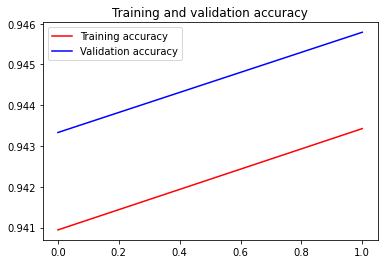

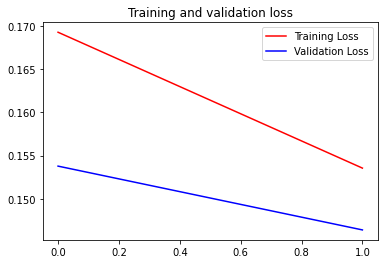

In [49]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()